In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [ ]:
# %cd /kaggle/working

In [ ]:
# from IPython.display import FileLink
# FileLink(r'train_alot_of_features.csv')

In [5]:
!pip install ../input/talib-package/talib_binary-0.4.19-cp37-cp37m-manylinux1_x86_64.whl
import talib as ta 

Processing /kaggle/input/talib-package/talib_binary-0.4.19-cp37-cp37m-manylinux1_x86_64.whl
talib-binary is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from lightgbm import early_stopping
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
import missingno as msno

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit 

import statsmodels.api as sm
from pylab import rcParams

from tqdm import tqdm


from talib import abstract



import time
import gc
import sys

# sys.path.insert(0, '../input/jpx-local-api')
# from local_api import local_api

In [9]:
def get_ta_features(df):
    """
    Get technical features from TA-Lib
    ref : https://www.kaggle.com/code/daosword/jpx-pytorch-neural-network-with-ta-lib-features
    """
    op = df['Open']
    hi = df['High']
    lo = df['Low']
    cl = df['Close']
    vo = df['Volume']
    
    # Overlap Studies
    df['BBANDS_upper'], df['BBANDS_middle'], df['BBANDS_lower'] = ta.BBANDS(cl, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['DEMA'] = ta.DEMA(cl, timeperiod=30)
    
    df['EMA7'] = ta.EMA(cl, 7)
    df['EMA15'] = ta.EMA(cl, 15)
    df['EMA30'] = ta.EMA(cl, 30)
    df['EMA90'] = ta.EMA(cl, 90)
    
    df['HT_TRENDLINE'] = ta.HT_TRENDLINE(cl)
    df['KAMA'] = ta.KAMA(cl, timeperiod=30)
    df['MA'] = ta.MA(cl, timeperiod=30, matype=0)
    df['MIDPOINT'] = ta.MIDPOINT(cl, timeperiod=14)
    df['SAR'] = ta.SAR(hi, lo, acceleration=0, maximum=0)
    df['SAREXT'] = ta.SAREXT(hi, lo, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
    df['SMA'] = ta.SMA(cl, timeperiod=30)
    df['T3'] = ta.T3(df['Close'], timeperiod=5, vfactor=0)
    df['TEMA'] = ta.TEMA(df['Close'], timeperiod=30)
    df['TRIMA'] = ta.TRIMA(df['Close'], timeperiod=30)
    df['WMA'] = ta.WMA(df['Close'], timeperiod=30)
    
    # Momentum Indicators
    df['ADX'] = ta.ADX(hi, lo, cl, timeperiod=14)
    df['ADXR'] = ta.ADXR(hi, lo, cl, timeperiod=14)
    df['APO'] = ta.APO(cl, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_down'], df['AROON_up'] = ta.AROON(hi, lo, timeperiod=14)
    df['AROONOSC'] = ta.AROONOSC(hi, lo, timeperiod=14)
    df['BOP'] = ta.BOP(op, hi, lo, cl)
    df['CCI'] = ta.CCI(hi, lo, cl, timeperiod=14)
    df['DX'] = ta.DX(hi, lo, cl, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = ta.MACD(cl, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MFI'] = ta.MFI(hi, lo, cl, vo, timeperiod=14)
    df['MINUS_DI'] = ta.MINUS_DI(hi, lo, cl, timeperiod=14)
    df['MINUS_DM'] = ta.MINUS_DM(hi, lo, timeperiod=14)
    df['MOM'] = ta.MOM(cl, timeperiod=10)
    df['PLUS_DI'] = ta.PLUS_DI(hi, lo, cl, timeperiod=14)
    df['PLUS_DM'] = ta.PLUS_DM(hi, lo, timeperiod=14)
    df['RSI'] = ta.RSI(cl, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = ta.STOCH(hi, lo, cl, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = ta.STOCHF(hi, lo, cl, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = ta.STOCHRSI(cl, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = ta.TRIX(cl, timeperiod=30)
    df['ULTOSC'] = ta.ULTOSC(hi, lo, cl, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = ta.WILLR(hi, lo, cl, timeperiod=14)
    
    # Volume Indicators
    df['AD'] = ta.AD(hi, lo, cl, vo)
    df['ADOSC'] = ta.ADOSC(hi, lo, cl, vo, fastperiod=3, slowperiod=10)
    df['OBV'] = ta.OBV(cl, vo)
    
    # Volatility Indicators
    df['ATR'] = ta.ATR(hi, lo, cl, timeperiod=14)
    df['NATR'] = ta.NATR(hi, lo, cl, timeperiod=14)
    df['TRANGE'] = ta.TRANGE(hi, lo, cl)
    
    # Cycle Indicators
    df['HT_DCPERIOD'] = ta.HT_DCPERIOD(cl)
    df['HT_DCPHASE'] = ta.HT_DCPHASE(cl)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = ta.HT_PHASOR(cl)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = ta.HT_SINE(cl)
    df['HT_TRENDMODE'] = ta.HT_TRENDMODE(cl)
    
    # Statistic Functions
    df['BETA'] = ta.BETA(hi, lo, timeperiod=5)
    df['CORREL'] = ta.CORREL(hi, lo, timeperiod=30)
    df['LINEARREG'] = ta.LINEARREG(cl, timeperiod=14) - cl
    df['LINEARREG_ANGLE'] = ta.LINEARREG_ANGLE(cl, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = ta.LINEARREG_INTERCEPT(cl, timeperiod=14) - cl
    df['LINEARREG_SLOPE'] = ta.LINEARREG_SLOPE(cl, timeperiod=14)
    df['STDDEV'] = ta.STDDEV(cl, timeperiod=5, nbdev=1)   
    
    return df

In [ ]:
data = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
# display(data)
# train = pd.read_csv('/kaggle/working/train_alot_of_features.csv').drop(columns='Unnamed: 0')

train = data.copy()

# using supplement data as test data
supp_data = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv')

# train_with_supp = pd.concat([train, supp_data]).reset_index(drop=True)
# train_with_supp = train.copy()
# train_with_supp

# TA Features
# train

In [19]:
def call_df_train(code):
    train = pd.read_csv('/kaggle/input/jpx-train-lot-ta-features/train_lot_ta_features.csv')
    code_df = train.loc[train.SecuritiesCode == code, :]
    del train
    gc.collect()
    return code_df

def call_df_eval(code):
    ev = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv')
    code_df = ev.loc[ev.SecuritiesCode == code, :]
    del ev
    gc.collect()
    
    code_df_added = add_features_train([code_df])
    
    return code_df_added

In [16]:
%%time
train_9997 = call_df_train(9997)

CPU times: user 26.6 s, sys: 1.16 s, total: 27.7 s
Wall time: 27.8 s


In [ ]:
%%time
eval_9997 = call_df_eval(9997)

In [10]:
train = pd.read_csv('/kaggle/input/jpx-train-lot-ta-features/train_lot_ta_features.csv')
train_1333 = train.loc[train.SecuritiesCode == 1333, :]

del train
gc.collect()

23260

code = 1333 만 써서 훈련데이터의 크기 때문에 시간 소요 하지 않도록 한다.

In [ ]:
def divideSecurities(df):
    sec_list = []
#     print('Divide securities individually..')
    for code in np.sort(df.SecuritiesCode.unique()):
        sec_list.append(df.loc[df.SecuritiesCode == code, :].reset_index(drop=True))
    return sec_list

sec_list = divideSecurities(train)

In [ ]:
def add_features_train(sec_list):
    df_list = []
    for df in tqdm(sec_list):
        
        # shadows
        df['upper_shadow'] = df['High'] - np.maximum(df['Open'], df['Close'])
        df['lower_shadow'] = np.minimum(df['Open'], df['Close']) - df['Low']
        

        ## Rolling features ##
        
        # lagged features
        # 날짜 단위이므로 7일전, 30일전, 180일전, 360일전 
        # lagged close, target (target 은 정확히 무엇? return인가)
        
        # lagged feature 계산하기 전 결측치 채워넣기
        df = df.fillna(method='ffill')
        
        
        
        # All indicators in ta
        df = get_ta_features(df.copy())
                
        # not add pattern recognition - feature importance 가 거의 0임. 
#         for indicator in ta.get_function_groups()['Pattern Recognition']:
#             df[str(indicator)] = getattr(ta,str(indicator))(df.Open, df.High, df.Low, df.Close)


        # fill ema features by backward -- 이렇게 채워진 것은 false data 이므로 일단 test 해보고 없애는 것을 검토하자.
        df = df.fillna(method='bfill')

    
        # volatility
        
        df_list.append(df)
        
        del df
        
    gc.collect()
    df_feature_added = pd.concat(df_list).sort_values(['Date','SecuritiesCode'])
    
    return df_feature_added



In [ ]:
# add feature to data

df_added = add_features_train(sec_list)
# df_added.to_csv('train_alot_of_features.csv', index=False)

# load data
# df_added = pd.read_csv('/kaggle/input/train-with-supp-feature-added-v1-all-cdl/train_with_supp_feature_added.csv')

# df_added

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [ ]:
df_ex = reduce_mem_usage(df_added).loc[df_added.SecuritiesCode == 1377, :]



In [ ]:
def add_features_infer(input_df, close_df): #input df 는 price 데이터
    
    df_list = []
    sec_list = divideSecurities(input_df)
    
    close_list = divideSecurities(close_df) # for rolling features
    
    for i in range(len(sec_list)):
        
        
        close = close_list[i] #.loc[close_df.SecuritiesCode == code, :].fillna(method='ffill')
        df = sec_list[i]
        
        # test data의 open, high, low, close 중 nan 있으면 이전 값에서 가져와 채움
        if df.loc[:, ['Open', 'High', 'Low', 'Close']].isna().any().any():
            df.loc[:, ['Open', 'High', 'Low', 'Close']] = close.loc[close['Date'] == close.iloc[-1]['Date'], ['Open', 'High', 'Low', 'Close']].values 
        
        # shadows
        df['upper_shadow'] = df['High'] - np.maximum(df['Open'], df['Close'])
        df['lower_shadow'] = np.minimum(df['Open'], df['Close']) - df['Low']

        # lagged features
        # 날짜 단위이므로 7일전, 30일전, 180일전, 360일전 
        # lagged close, target (target 은 정확히 무엇? return인가)
        
        ## Rolling features ##
        # TA-lib features - RSI, EMA 7-90
        df = get_ta_features(df)

        
        
#         for indicator in ta.get_function_groups()['Pattern Recognition']:
#             df[str(indicator)] = getattr(ta,str(indicator))(df.Open, df.High, df.Low, df.Close)


        # volatility
        
        df_list.append(df)
    
    df_feature_added = pd.concat(df_list)
    
    return df_feature_added




In [11]:
def preprocess_train(df):
    
    # remove columns - Date removed temporarily
    dfc = df.drop(columns=['RowId', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag'])
    
    
#     minmax = MinMaxScaler()
    stdsc = StandardScaler()
    ordinal = OrdinalEncoder()

    target = ['Target']
#     minmax_features = ['Date']
    ord_features = ['SecuritiesCode'] 
#     scaled_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'upper_shadow', 'lower_shadow',
#                       'RSI', 'EMA7', 'EMA15', 'EMA30', 'EMA90'] + [c for c in df.columns if c.startswith('CDL')] # pattern recognition features
    scaled_features = [i for i in df.columns if i not in ['Date', 'RowId', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
                                                         'Target', 'SecuritiesCode']]
    
    
#     date_scaled = minmax.fit_transform(dfc.loc[:,minmax_features])
    date_code_ord = ordinal.fit_transform(dfc.loc[:,ord_features])
    scaled = stdsc.fit_transform(dfc.loc[:,scaled_features])
    
#     display(pd.DataFrame(date_code_ord, columns=ord_features))
#     display(pd.DataFrame(scaled, columns=scaled_features))
    
    
    dfc_scaled = pd.concat([# pd.DataFrame(date_scaled, columns=minmax_features),
                            pd.DataFrame(date_code_ord, columns=ord_features),
                            pd.DataFrame(scaled, columns=scaled_features)], 
                            axis=1)
    dfc_scaled = pd.concat([df['Date'].reset_index(drop=True), dfc_scaled],
                           axis=1)
    dfc_scaled = dfc_scaled.set_index(['Date'])

    y = dfc.set_index(['Date']).loc[:, ['Target']]
    
    
    return dfc_scaled, y, [ordinal, stdsc]
    

X_scaled, y, trained_scalers = preprocess_train(train_1333)  # 2021-12-06부터 test 시작이므로 그 전까지만 이용한다.

# X_scaled
y

,Target
Date,
2017-01-04,0.006153
2017-01-05,-0.010704
2017-01-06,-0.015460
2017-01-10,-0.001570
2017-01-11,0.015720
...,...
2021-11-29,0.009660
2021-11-30,0.001739
2021-12-01,0.023880


In [ ]:
def preprocess_inference(df, trained_scalers: list):
    ordinal = trained_scalers[0]
    stdsc = trained_scalers[1]
    
      
    # remove columns - Date removed temporarily
    dfc = df.drop(columns=['RowId', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag'])
    
    
    target = ['Target']
    ord_features = ['SecuritiesCode'] 
#     scaled_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'upper_shadow', 'lower_shadow',
#                       'RSI', 'EMA7', 'EMA15', 'EMA30', 'EMA90'] + [c for c in df.columns if c.startswith('CDL')] # pattern recognition features
    scaled_features = [i for i in df.columns if i not in ['Date', 'RowId', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
                                                         'Target', 'SecuritiesCode']]
    
    date_code_ord = ordinal.transform(dfc.loc[:,ord_features])
    scaled = stdsc.transform(dfc.loc[:,scaled_features])
    dfc_scaled = pd.concat([pd.DataFrame(date_code_ord, columns=ord_features),
                            pd.DataFrame(scaled, columns=scaled_features)], axis=1)

    
    return dfc_scaled
    

# X_test_scaled = preprocess_train(df_added, trained_scalers)

# X_test_scaled

In [8]:
train.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,60.0,...,-0.9970,-0.651,0,1.4810,0.9420,-19.94,-68.75,13.516,-2.574,3.555
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,3.5,...,-0.7524,-0.998,0,0.5835,0.9175,-7.60,-70.30,28.750,-2.795,7.680
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,30.0,...,-0.9995,-0.727,0,0.9585,0.9253,45.44,-79.25,113.900,-5.266,29.830


In [24]:
gc.collect()

37293

In [12]:
# base model - lgbm 
lgb = LGBMRegressor()
lgb.fit(X_scaled, y)




LGBMRegressor()

feature importance : only 9997

,Value,Feature
0,137,CORREL
1,131,BOP
2,105,NATR
3,93,MFI
4,91,STDDEV
...,...,...
70,2,EMA7
71,1,SAR
72,0,SecuritiesCode
73,0,SMA


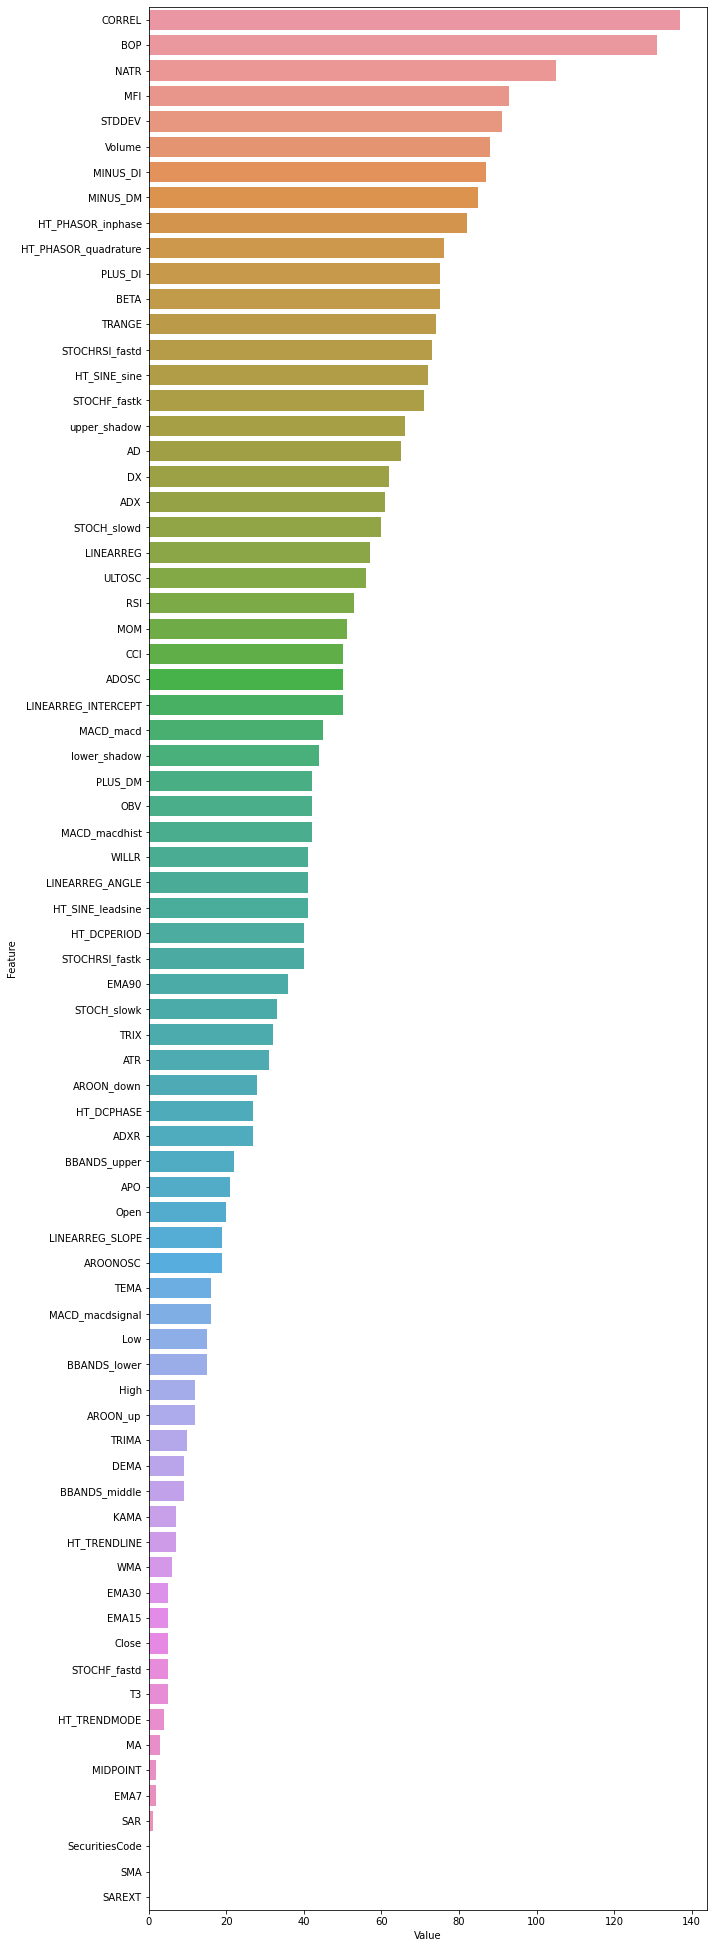

In [17]:
X_scaled, y, trained_scalers = preprocess_train(train_9997)
lgb = LGBMRegressor()
lgb.fit(X_scaled, y)
feature_imp = pd.DataFrame(
    sorted(zip(lgb.feature_importances_, X_scaled.columns), reverse=True),
    columns = ['Value', 'Feature'])
display(feature_imp)
plt.figure(figsize=(10,35))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.show()

feature importance - all securities

,Value,Feature
0,248,NATR
1,129,Volume
2,128,HT_PHASOR_quadrature
3,116,AROON_down
4,115,CCI
...,...,...
70,3,MA
71,2,WMA
72,2,EMA7
73,2,EMA30


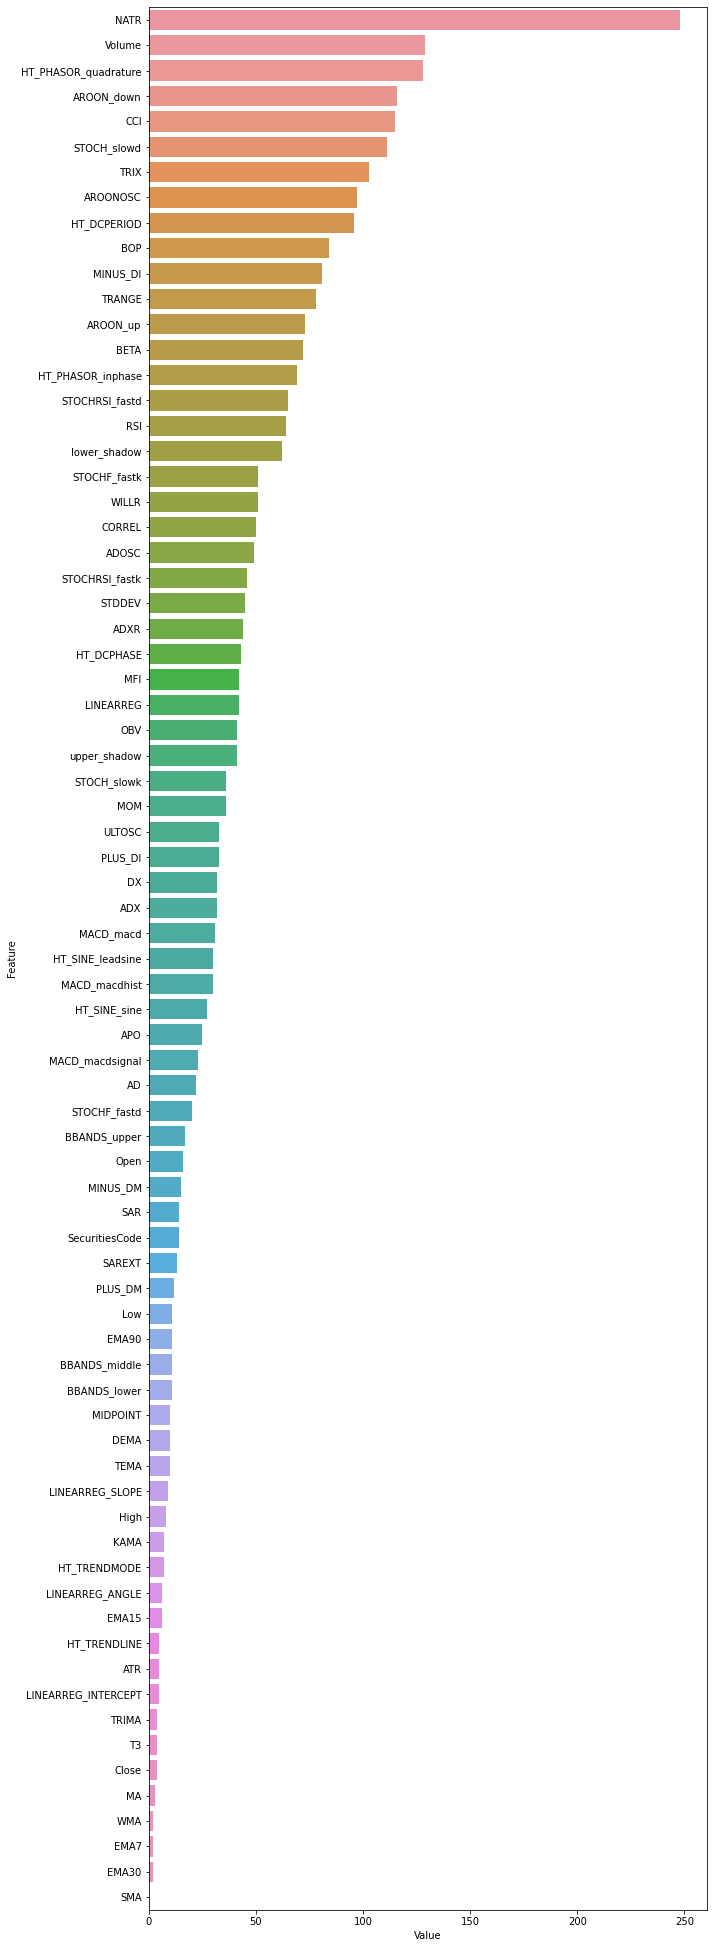

In [12]:
feature_imp = pd.DataFrame(
    sorted(zip(lgb.feature_importances_, X_scaled.columns), reverse=True),
    columns = ['Value', 'Feature'])
display(feature_imp)
plt.figure(figsize=(10,35))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.show()

In [18]:
# top 15 features
feature_imp.iloc[:10]['Feature'].values

array(['NATR', 'Volume', 'HT_PHASOR_quadrature', 'AROON_down', 'CCI',
       'STOCH_slowd', 'TRIX', 'AROONOSC', 'HT_DCPERIOD', 'BOP'],
      dtype=object)

In [13]:
# permutation importance - 1333
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lgb, random_state=1).fit(X_scaled, y)
eli5.show_weights(perm, feature_names = X_scaled.columns.tolist())

Weight,Feature
0.0864 ± 0.0045,EMA7
0.0764 ± 0.0093,HT_PHASOR_quadrature
0.0445 ± 0.0088,ADOSC
0.0432 ± 0.0042,HT_DCPHASE
0.0427 ± 0.0034,HT_PHASOR_inphase
0.0410 ± 0.0064,BOP
0.0397 ± 0.0042,upper_shadow
0.0392 ± 0.0025,STOCH_slowk
0.0389 ± 0.0033,Volume
0.0376 ± 0.0021,MOM


In [18]:
# permutation importance - 9997
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lgb, random_state=1).fit(X_scaled, y)
eli5.show_weights(perm, feature_names = X_scaled.columns.tolist())

Weight,Feature
0.1057 ± 0.0176,CORREL
0.0743 ± 0.0035,BOP
0.0532 ± 0.0048,TRANGE
0.0529 ± 0.0032,NATR
0.0487 ± 0.0035,MFI
0.0483 ± 0.0036,PLUS_DI
0.0476 ± 0.0051,MACD_macd
0.0444 ± 0.0069,MINUS_DM
0.0442 ± 0.0052,STDDEV
0.0396 ± 0.0026,HT_PHASOR_inphase


### Evaluation

In [ ]:
def timeseriesCVerror(X, y, fold, loss, Model):#model, loss_function):
    errors = []
    tscv = TimeSeriesSplit(test_size=120)
    # split input : index date
    grid = X.index.unique()
    
    k = 0
    for train_idx, test_idx in tscv.split(grid):
        t0 = time.time()
        k += 1
        print(f'========Training fold {k}========')
        
        print('training size:', len(train_idx), '  test size:', len(test_idx))
#         print(grid[train_idx])
        X_train, y_train = X.loc[grid[train_idx], :], y.loc[grid[train_idx], :]
        X_test, y_test = X.loc[grid[test_idx], :], y.loc[grid[test_idx], :]
        
        mod = Model.fit(X_train, y_train,           
                        eval_set=[(X_test, y_test)],
                        eval_metric="rmse",
                        callbacks=[early_stopping(stopping_rounds=10)]
                       )
        y_pred = mod.predict(X_test)
        error = loss(y_pred, y_test)
        errors.append(error)
        
        print(f'Fold {k} finished with loss: {error:.10f} in {time.time() - t0:.4f}s\n\n')
        
#     print(errors)
    print(f'Average Loss: {np.mean(errors):.10f}')
    return


timeseriesCVerror(X_scaled, y, 10, mean_squared_error, 
                  LGBMRegressor(seed=47)
                 )

In [ ]:
def evaluate(df):
    df_added = add_features_train(df, sec_list)
    X_scaled, y, trained_scalers = preprocess_train(df_added)

    y_pred = lgb.predict(X_scaled)
    print(mean_squared_error(y_pred, y))
    return

evaluate(supp_data)

In [ ]:
def evaluate(df):
    df_added = add_features_train(df, sec_list)
    X_scaled, y, trained_scalers = preprocess_train(df_added)

    y_pred = lgb.predict(X_scaled.loc[:, 
                                      ['RSI', 'lower_shadow', 'Volume', 
                                       'upper_shadow', 'EMA90','SecuritiesCode']])
    print(mean_squared_error(y_pred, y))
    return

evaluate(supp_data)

## Test

In [ ]:
# import jpx_tokyo_market_prediction
# env = jpx_tokyo_market_prediction.make_env()
# iter_test = env.iter_test()

In [ ]:
for i, (prices, options, financials, trades, secondary_prices, sample_prediction) in enumerate(iter_test):
#     t0 = time.time()
    
    # 이전 데이터와 합치고 최근 140일치만 이용한다
    today = prices.iloc[0]['Date']
    lastday = str(pd.to_datetime(today) - pd.DateOffset(140))
    
    if i == 0:
        close_df = pd.concat([
            train_with_supp.loc[
                (train_with_supp['Date'] > lastday) & (train_with_supp['Date'] < today), 
                    ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']],
                prices.loc[:, ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']]
            ]).reset_index(drop=True)
        
    else:
        close_df = pd.concat([
            close_df.loc[
                (close_df['Date'] > lastday) & (close_df['Date'] < today), 
                    ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']],
                prices.loc[:, ['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close']]
            ]).reset_index(drop=True)
        

    feat = add_features_infer(prices, close_df)
    X = preprocess_inference(feat, trained_scalers)

    # X, y
    X['Target'] = lgb.predict(X)
    X['Rank'] = (X['Target'].rank(method='first', ascending=False)-1).astype(int)
    sample_prediction['Rank'] = X['Rank'].values
    
    # check Rank
    assert sample_prediction["Rank"].notna().all()
    assert sample_prediction["Rank"].min() == 0
    assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1
#     display(sample_prediction)

    env.predict(sample_prediction)
#     print(time.time() - t0)